In [ ]:
################################################################################
########################          Yelp Reviews          ######################## 
########################   Classification : LSTM        ######################## 
########################  Stars on Reviews: 1 & 2 vs 5  ########################
################################################################################

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import time
import datetime
from datetime import datetime, timedelta
from timeit import default_timer as timer
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model
from keras.layers import Embedding
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Mon Apr 18 19:41:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|            

In [ ]:
# Reproducibility in TF and Pytorch 
def init_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] ='true'
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    tf.random.set_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [ ]:
init_seeds(seed=42)

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


,stars_reviews,cleanReview
index,,
2,5.0,"[wonderful, place, get, lunch, staff, friendly..."
3,5.0,"[dedicated, loving, memory, gary, feldman, gre..."
5,5.0,"[love, place, everything, menu, delicious, lik..."
7,5.0,"[truely, hidden, gem, place, greatest, buffalo..."
9,5.0,"[seriously, great, fresh, fantastic, food, spo..."


In [ ]:
# Remove comma from tokenize to make one string
df = df.copy()
df['cleanReview'] = df['cleanReview'].apply(lambda x: ','.join(map(str, x)))
df.loc[:,'cleanReview'] =  df['cleanReview'].str.replace(r',', ' ', regex=True)
df.head()

,stars_reviews,cleanReview
index,,
2,5.0,wonderful place get lunch staff friendly effic...
3,5.0,dedicated loving memory gary feldman greatest ...
5,5.0,love place everything menu delicious like tuna...
7,5.0,truely hidden gem place greatest buffalo chick...
9,5.0,seriously great fresh fantastic food spot pric...


In [ ]:
# Recode to binary
df = df.copy()
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770743
dtype: int64

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

In [ ]:
# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.1, stratify=label,
                                                    random_state=seed)

In [ ]:
class KerasTokenizer(object):
    """
    Fit and convert text to sequences for use in a Keras model.
    num_words = max number of words 
    maxlen  = max length of sequences
    """
    def __init__(self, num_words=100000, maxlen=300):
        self.tokenizer = text.Tokenizer(num_words=num_words)
        self.maxlen = maxlen
        
    def fit(self, X, y):
        self.tokenizer.fit_on_texts(X)
        return self
        
    def transform(self, X):
        return sequence.pad_sequences(self.tokenizer.texts_to_sequences(X), maxlen=self.maxlen)
    

In [ ]:
km  = Pipeline([('Keras Tokenizer', KerasTokenizer(num_words=100000, maxlen=500))]) 

In [ ]:
X_train = km.fit_transform(X_train)
X_test = km.fit_transform(X_test)

In [ ]:
# Write results to DL Results
%cd /content/drive/MyDrive/Yelp_Reviews/DL/LSTM/ReviewStars/Models/

In [ ]:
import datetime
!rm -rf /logs/

%load_ext tensorboard

log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [ ]:
# Set up callbacks
filepath = 'LSTM_weights_only_b1024_6.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='val_accuracy', 
                                  save_best_only = True, mode='max'), 
                  tensorboard_callback]

In [ ]:
# Define model structure
embedding_size = 300
input_ = Input(shape=(500,))
x = Embedding(100000, embedding_size)(input_)
x = Dropout(0.1)(x)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.0))(x) 
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='tanh')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_, outputs=x)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          30000000  
                                                                 
 dropout (Dropout)           (None, 500, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 500, 100)         140400    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050  

In [ ]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, 
                    batch_size=1024, callbacks=callbacks_list)

Epoch 1/5
1355/1355 [==============================] - 4278s 3s/step - loss: 0.1079 - accuracy: 0.9587 - val_loss: 0.5215 - val_accuracy: 0.8124
Epoch 2/5
1355/1355 [==============================] - 4252s 3s/step - loss: 0.0702 - accuracy: 0.9746 - val_loss: 0.5407 - val_accuracy: 0.8078
Epoch 3/5
1355/1355 [==============================] - 4247s 3s/step - loss: 0.0578 - accuracy: 0.9792 - val_loss: 0.5592 - val_accuracy: 0.8143
Epoch 4/5
1355/1355 [==============================] - 4226s 3s/step - loss: 0.0486 - accuracy: 0.9828 - val_loss: 0.5943 - val_accuracy: 0.8103


In [ ]:
# Save model
model.save('./LSTM_batch1024_5epochs_6_tf.h5', save_format='tf')

# Load model for more training or later use
#model = tf.keras.models.load_model('./LSTM_batch1024_5epochs_6_tf.h5')

# Show the model architecture
#model.summary()

In [ ]:
acc = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

4818/4818 [==============================] - 1253s 260ms/step - loss: 0.5943 - accuracy: 0.8103
Test set
  Loss: 0.594
  Accuracy: 0.810


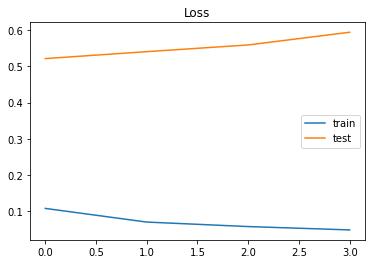

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

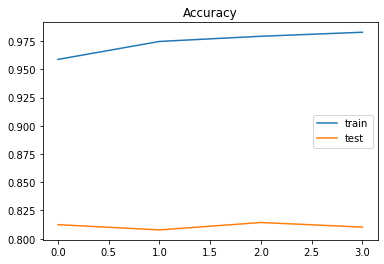

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
# Load model for more training or later use
model = tf.keras.models.load_model('./LSTM_batch1024_5epochs_6_tf.h5')

# Show the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          30000000  
                                                                 
 dropout (Dropout)           (None, 500, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 500, 100)         140400    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050  

In [ ]:
# Set up callbacks
filepath = 'LSTM_weights_only_b1024_7.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience = 5),
                  ModelCheckpoint(filepath, monitor='val_accuracy', 
                                  save_best_only = True, mode='max'), 
                  tensorboard_callback]

In [ ]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=7, 
                    batch_size=1024, callbacks=callbacks_list)

Epoch 1/7
1355/1355 [==============================] - 4227s 3s/step - loss: 0.0323 - accuracy: 0.9891 - val_loss: 0.7143 - val_accuracy: 0.8073
Epoch 2/7
1355/1355 [==============================] - 4247s 3s/step - loss: 0.0252 - accuracy: 0.9915 - val_loss: 0.8084 - val_accuracy: 0.8033
Epoch 3/7
1355/1355 [==============================] - 4260s 3s/step - loss: 0.0205 - accuracy: 0.9932 - val_loss: 0.8668 - val_accuracy: 0.8069
Epoch 4/7
1355/1355 [==============================] - 4276s 3s/step - loss: 0.0175 - accuracy: 0.9942 - val_loss: 0.9470 - val_accuracy: 0.8030
Epoch 5/7
1355/1355 [==============================] - 4271s 3s/step - loss: 0.0319 - accuracy: 0.9884 - val_loss: 0.7830 - val_accuracy: 0.8062
Epoch 6/7
1355/1355 [==============================] - 4262s 3s/step - loss: 0.0257 - accuracy: 0.9907 - val_loss: 0.8415 - val_accuracy: 0.8048


In [ ]:
# Save model
model.save('./LSTM_batch1024_5epochs_7_tf.h5', save_format='tf')
5
# Load model for more training or later use
#model = tf.keras.models.load_model('./LSTM_batch1024_5epochs_7_tf.h5')

# Show the model architecture
#model.summary()

5

In [ ]:
acc = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

4818/4818 [==============================] - 1138s 236ms/step - loss: 0.8415 - accuracy: 0.8048
Test set
  Loss: 0.841
  Accuracy: 0.805


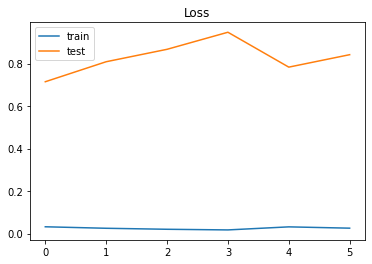

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

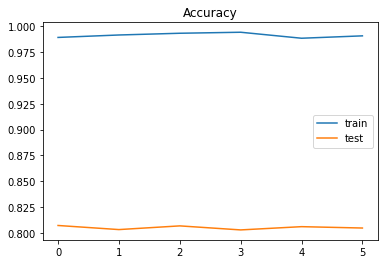

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()